Stanza has provided a relatively easy [tutorial](https://github.com/stanfordnlp/stanza-train) to train it's pipeline. 

However, what if I wanted to train a pipeline, `tokenizer` in this case, by myself? 

Although using stanza is super easy, but the documentation has not explained about how do we train stanza pipelines' using our custom data. 


In [4]:
!pip list | grep stanza

stanza                 1.1.1


Here I will show how to manually train stanza tokenizer model in Khmer language, which does not have any token/word separators (see [khmertimeskh.com](https://www.khmertimeskh.com/category/khmer/) for example). 

The khmer data will be taken from [Asian Language Treebank Project](https://www2.nict.go.jp/astrec-att/member/mutiyama/ALT/), conducted by NICT and UCSY.

sample data:
```
SNT.80188.1	អ៊ីតាលី បាន ឈ្នះ លើ ព័រទុយហ្គាល់ 31-5 ក្នុង ប៉ូល C នៃ ពិធី ប្រកួត ពាន រង្វាន់ ពិភព លោក នៃ កីឡា បាល់ ឱប ឆ្នាំ 2007 ដែល ប្រព្រឹត្ត នៅ ប៉ាស ឌេស ប្រីន ក្រុង ប៉ារីស បារាំង ។
SNT.80188.2	អេនត្រា ម៉ាស៊ី បាន ស៊ុត ចូល ក្នុង នាទី ទី បួន គ្រា ដំបូង នៃ ពាក់ កណ្តាល សំរាប់ អ៊ីតាលី ។
```


The data has been seperated by spaces to indicate a token in Khmer, so we should use that as our label

In [59]:
docs = list()
with open('data/km-nova-181101/data_km.km-tok.nova', encoding='utf-8') as f:
    for sentence in f:
        doc_id, doc = sentence.split('\t')
        docs.append((doc_id, doc))

In [60]:
from stanza.models.tokenize.trainer import Trainer
from stanza.models.tokenize.data import DataLoader
from stanza.models.common.doc import Document
from stanza.models.tokenize.utils import output_predictions

In [61]:
feat_funcs = ['space_before']
batch_size = 10

train_batch = DataLoader(
    dict(
        batch_size=batch_size,
        lang='km',
        feat_funcs=feat_funcs,
        feat_dim=len(feat_funcs),
        max_seqlen=300), 
    input_text='\n'.join([docs[i][1] for i in range(len(docs[:50]))]))

Stanza tokenizer model will try to predict **each character** into 4 classes:
```
0 = usual character, no separation needed
1 = end of token
2 = end of sentence
3 = end of mwt
```

And we will be looking to use `1` as our label for each space, but we won't be needing the spaces

In [62]:
def update_sentences(paragraphs: list) -> list:
    """
    modify sentences in km language using format (char_id, label, feature, original_char).
    Since km is a language without spaces, we wanted to label `1` for denoting that it should be separated up to that point
     """
    new_paragraphs = list()
    for paragraph_id, paragraph in enumerate(paragraphs):
        new_paragraphs.append(list())
        for sentence_id, sentence in enumerate(paragraph):
            new_paragraphs[paragraph_id].append(list())
            
            for char_id, label, feature, char in sentence:
                if char == ' ':
                    prev_row = new_paragraphs[paragraph_id][sentence_id][-1]
                    new_paragraphs[paragraph_id][sentence_id][-1] = (prev_row[0], 1, [], prev_row[3])
                else:
                    new_paragraphs[paragraph_id][sentence_id].append((char_id, feature[0], [], char))
    return new_paragraphs

In [63]:
train_batch.sentences = update_sentences(train_batch.sentences)

In [64]:
use_cuda = True
# feature function
feat_funcs = []

train_args = dict(
    emb_dim=32,
    hidden_dim=64,
    conv_filters='1,9',
    residual=True,
    hierarchical=False,
    hier_invtemp=0.5,
    input_dropout=True,
    conv_res=None,
    rnn_layers=1,
    max_grad_norm=1.0,
    anneal=.999,
    anneal_after=2000,
    lr0=1e-3,
    dropout=0.20,
    unit_dropout=0.20,
    feat_dim=len(feat_funcs),
    tok_noise=0.02,
    weight_decay=0.0,
    lang='km'
)

In [65]:
vocab = train_batch.vocab
train_args['vocab_size'] = vocab.size

In [66]:
trainer = Trainer(args=train_args, vocab=vocab, use_cuda=use_cuda)

In [67]:
from tqdm.notebook import tqdm_notebook

In [68]:
N = len(train_batch)
epoch = 200
losses = list()
for step in tqdm_notebook(range(int(N * epoch / batch_size) + 1)):
    batch = train_batch.next(unit_dropout=train_args['unit_dropout'])
    loss = trainer.update(batch)
    losses.append(loss)

In [69]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

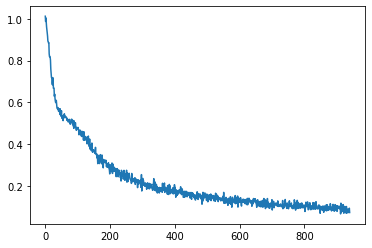

In [70]:
plt.plot(np.arange(len(losses)), losses)
plt.show()

In [71]:
from stanza.models.tokenize.utils import output_predictions

In [72]:
trainer.args['batch_size'] = batch_size
trainer.args['shorthand'] = 'km'

In [74]:
n_test_doc = 10
test_text = '\n\n'.join([docs[i][1].replace(' ', '').replace('\n', '') for i in range(n_test_doc)])

In [77]:
batch_size = n_test_doc

test_batch = DataLoader(
    dict(
        batch_size=batch_size,
        lang='km',
        feat_funcs=feat_funcs,
        feat_dim=len(ff),
        max_seqlen=300), 
    input_text=test_text,
    # we should make sure we pass the vocab used in train dataloader
    # otherwise the parser will output strange result
    vocab=vocab)

In [78]:
_, _, _, doc = output_predictions(None, trainer, test_batch, vocab, None, 300, None, False)

In [80]:
' '.join([d['text'] for d in doc[0]])

'អ៊ីតាលី បាន ឈ្នះ លើ ព័រទុយហ្គាល់ 31-5 ក្នុង ប៉ូល C នៃ ពិធី ប្រកួត ពាន រង្វាន់ ពិភព លោក នៃ កីឡា បាល់ ឱប ឆ្នាំ 2007 ដែល ប្រព្រឹត្ត នៅ ប៉ាស ឌេស ប្រីន ក្រុង ប៉ារីស បារាំង ។'

It does seems that our tokenizer for km has worked!